In [96]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk 
import sqlalchemy
import seaborn as sns
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.base import TransformerMixin
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split, cross_val_score, KFold
import xgboost as xgb
from sklearn import metrics
from scipy.stats import skew
import keras

%matplotlib inline

In [97]:
def convertNA(value):
    try:
        if np.isnan(value):
            return "None"
        else:
            return value
    except:
        return value

In [98]:
train  = pd.read_csv("../assets/train.csv")
test = pd.read_csv("../assets/test.csv")

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

categories = [u"Alley","Fence","PoolQC","GarageCond","GarageQual","GarageFinish","MiscFeature","GarageType","FireplaceQu","BsmtFinType2","BsmtFinType1","BsmtCond","BsmtQual"]
for column in categories:
    all_data[column] = all_data[column].apply(convertNA)

all_data.fillna(all_data.mean(),inplace=True)

all_data = pd.get_dummies(all_data)

X = all_data.iloc[:1460,:]
X_test = all_data.iloc[1460:,:]
y = train["SalePrice"]

In [99]:
def runRFModel(X,y,X_test,predictTest = False):
    cv = KFold(len(y),shuffle=False)
    rf = RandomForestRegressor(random_state=5)
    rfScore = cross_val_score(rf,X,y,cv=cv, n_jobs=-1)
    model = rf.fit(X,y)
    if predictTest:
        return model.predict(X_test)
    else:
        return model.predict(X)
    

In [153]:
def makeSubmission(predictions,testDF):
    submission = pd.DataFrame()
    submission["Id"] = testDF["Id"]
    submission["SalePrice"] = predictions
    submission.to_csv("../assets/submission.csv", index=False)

In [101]:
def rmsle(y_predict,y_actual):
    return np.sqrt(np.mean(np.power(np.log1p(y_predict) - np.log1p(y_actual), 2)))

In [102]:
def modelfit(alg, X, X_test, y, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X.values, label=y.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y,eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtest_predictions = alg.predict(X_test)
    
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    #Print model report:
    print "\nModel Report"
    #print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['SalePrice'].values.astype(float), dtrain_predictions.astype(float))
    #print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['SalePrice'], dtrain_predprob)
    print "Score: ", metrics.r2_score(y,dtrain_predictions)
    print "RMSLE: ", rmsle(y,dtrain_predictions)
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
#     submission = pd.DataFrame()
#     submission["Id"] = dtest["Id"].values.astype(int)
#     submission["SalePrice"] = dtest_predictions
#     submission.to_csv("../assets/submission.csv", index=False)

In [103]:
def runXGB(X,y,X_test, predictTest = False):
    xgb1 = xgb.XGBRegressor(
     learning_rate =0.01,
     n_estimators=1000,
     max_depth=6,
     min_child_weight=3,
     gamma=0,
     subsample=0.65,
     colsample_bytree=0.65,
     objective= 'reg:linear',
     nthread=4,
     scale_pos_weight=1,
     reg_alpha= 1e-05,
     seed=27)
    model = modelfit(xgb1, X, X_test, y)
    if predictTest:
        return xgb1.predict(X_test)
    else:
        return xgb1.predict(X)

In [104]:
def runLinReg(X,y,X_test, predictTest = False):
    #log transform the target:
    #y = np.log1p(y)

    #log transform skewed numeric features:
    numeric_feats = X.dtypes[X.dtypes != "object"].index

    skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
    skewed_feats = skewed_feats[skewed_feats > 0.75]
    skewed_feats = skewed_feats.index

    X[skewed_feats] = np.log1p(X[skewed_feats])
    X_test[skewed_feats] = np.log1p(X[skewed_feats])
    
    model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X, y)
    if predictTest:
        return model_lasso.predict(X_test)
    else:
        return model_lasso.predict(X)


Model Report
Score:  0.989275164204
RMSLE:  0.0549405894513


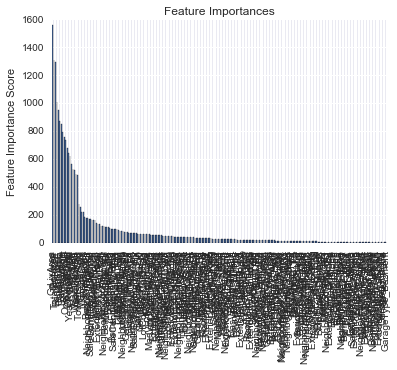

In [156]:
rf_predictions = runRFModel(X,y,X_test,predictTest =True)
xgb_predictions = runXGB(X,y,X_test,predictTest =True)
lr_predictions = runLinReg(X,y,X_test,predictTest =True)

In [157]:
level1 = pd.DataFrame()
level1["rf"] = rf_predictions
level1["xgb"] = xgb_predictions
level1["lr"] = lr_predictions
level1["y"] = y
level1

net_X = level1.values[:,0:3]
net_Y = level1.values[:,3]

net_Y

array([ 208500.,  181500.,  223500., ...,  210000.,  266500.,  142125.])

In [158]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

# define base mode
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(3, input_dim=3, init='normal', activation='relu'))
    model.add(Dense(1, init='normal'))
    # Compile model
    model.compile(loss='msle', optimizer='adam')
    return model

In [159]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=0)

In [124]:
kfold = KFold(n=1460, n_folds=10, random_state=seed)
results = cross_val_score(estimator, net_X, net_Y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: 101.34 (66.34) MSE


In [128]:
model = baseline_model()

In [140]:
model.fit(net_X,net_Y,nb_epoch=300)

Epoch 1/300
1460/1460 [==============================] - 0s - loss: 0.0026     
Epoch 2/300
1460/1460 [==============================] - 0s - loss: 0.0027     
Epoch 3/300
1460/1460 [==============================] - 0s - loss: 0.0027     
Epoch 4/300
1460/1460 [==============================] - 0s - loss: 0.0026     
Epoch 5/300
1460/1460 [==============================] - 0s - loss: 0.0026     
Epoch 6/300
1460/1460 [==============================] - 0s - loss: 0.0027     
Epoch 7/300
1460/1460 [==============================] - 0s - loss: 0.0026     
Epoch 8/300
1460/1460 [==============================] - 0s - loss: 0.0026     
Epoch 9/300
1460/1460 [==============================] - 0s - loss: 0.0026     
Epoch 10/300
1460/1460 [==============================] - 0s - loss: 0.0026     
Epoch 11/300
1460/1460 [==============================] - 0s - loss: 0.0026     
Epoch 12/300
1460/1460 [==============================] - 0s - loss: 0.0026     
Epoch 13/300
1460/1460 [=============

In [160]:
model.predict(net_X)

array([[ 111505.8125  ],
       [ 114372.40625 ],
       [ 135272.703125],
       ..., 
       [ 122023.859375],
       [ 114579.171875],
       [ 183963.8125  ]], dtype=float32)

In [161]:
net_Y

array([ 208500.,  181500.,  223500., ...,  210000.,  266500.,  142125.])

In [162]:
loss_and_metrics = model.evaluate(net_X, net_Y, batch_size=1400)
print
print loss_and_metrics


1400/1459 [===========================>..] - ETA: 0s
0.255477692572


In [163]:
rmsle(model.predict(net_X),net_Y)

0.52223392637036337

In [164]:
model.predict(net_X)

array([[ 111505.8125  ],
       [ 114372.40625 ],
       [ 135272.703125],
       ..., 
       [ 122023.859375],
       [ 114579.171875],
       [ 183963.8125  ]], dtype=float32)

In [165]:
net_Y

array([ 208500.,  181500.,  223500., ...,  210000.,  266500.,  142125.])

In [166]:
makeSubmission(model.predict(net_X),test)